In [1]:
import uproot
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/sbnd/app/users/brindenc/sbnd_helpers/sbnd_python')
#My imports
import ttree
import caf_constants
import time
import caf
import plotters
import helpers
import utils

%load_ext autoreload
%autoreload 2

In [2]:
#Constants
NOM_POT = 10e20

mcnu_bad_keys = ['rec.mc.nu.genVersion',	'rec.mc.nu.prim.daughters','rec.mc.nu.wgt.univ']
mcprim_bad_keys = ['rec.mc.nu.prim.daughters']
pfp_bad_keys = ['rec.slc.reco.pfp.shw.truth.matches.G4ID',
                'rec.slc.reco.pfp.shw.truth.matches.energy',
                'rec.slc.reco.pfp.shw.truth.matches.energy_completeness',
                'rec.slc.reco.pfp.shw.truth.matches.energy_purity',
                'rec.slc.reco.pfp.shw.truth.matches.hit_completeness',
                'rec.slc.reco.pfp.shw.truth.matches.hit_purity',
                'rec.slc.reco.pfp.trk.truth.matches.G4ID',
                'rec.slc.reco.pfp.trk.truth.matches.energy',
                'rec.slc.reco.pfp.trk.truth.matches.energy_completeness',
                'rec.slc.reco.pfp.trk.truth.matches.energy_purity',
                'rec.slc.reco.pfp.trk.truth.matches.hit_completeness',
                'rec.slc.reco.pfp.trk.truth.matches.hit_purity'
                ]

#Folder and file names
data_folder = '/sbnd/data/users/brindenc/analyze_sbnd/nue/v09_72_01/'
plots_folder = '/sbnd/app/users/brindenc/analyze_sbnd/nue/reco_studies'
file_labels = ['','cheat','cheat_vtx']
fnames = ['caf_nue_samegen.root','caf_nue_samegen_cheat.root','caf_nue_samegen_cheat_vtx.root']
sample_pots = [None]*len(fnames)
normalizations = sample_pots.copy()
trees = sample_pots.copy()
mcprims = sample_pots.copy()
pfps = sample_pots.copy()

#Get tree and POT
for i,fname in enumerate(fnames):
  tree = uproot.open(f'{data_folder}{fname}')
  trees[i] = tree['recTree;1']
  sample_pots[i] = tree['TotalPOT;1'].to_numpy()[0][0]
  normalizations[i] = NOM_POT/sample_pots[i]

#NORMALIZATION = NOM_POT/SAMPLE_POT #Renormalize all counts to this number

In [3]:
mcnu_bad_keys = ['rec.mc.nu.genVersion',	'rec.mc.nu.prim.daughters','rec.mc.nu.wgt.univ']
mcprim_bad_keys = ['rec.mc.nu.prim.daughters']
pfp_bad_keys = ['rec.slc.reco.pfp.shw.truth.matches.G4ID',
                'rec.slc.reco.pfp.shw.truth.matches.energy',
                'rec.slc.reco.pfp.shw.truth.matches.energy_completeness',
                'rec.slc.reco.pfp.shw.truth.matches.energy_purity',
                'rec.slc.reco.pfp.shw.truth.matches.hit_completeness',
                'rec.slc.reco.pfp.shw.truth.matches.hit_purity',
                'rec.slc.reco.pfp.trk.truth.matches.G4ID',
                'rec.slc.reco.pfp.trk.truth.matches.energy',
                'rec.slc.reco.pfp.trk.truth.matches.energy_completeness',
                'rec.slc.reco.pfp.trk.truth.matches.energy_purity',
                'rec.slc.reco.pfp.trk.truth.matches.hit_completeness',
                'rec.slc.reco.pfp.trk.truth.matches.hit_purity'
                ]

In [4]:
def intersection_of_sets(sets):
  """
  Find the indices of the particles in the intersection of three sets.
  """
  intersection = sets[0]
  for i,s in enumerate(sets):
    intersection = intersection.intersection(s)
  return list(intersection)
  
def intersection_of_dfs(dfs):
  """
  Find intersection of list of dataframes. Should be pfps, mcprims, whateva
  """  
  indices_sets = [set(df.index.drop_duplicates()) for df in dfs] #Convert indeces to sets
  common_inds = intersection_of_sets(indices_sets) #Get common inds
  ret_dfs = [df.loc[common_inds] for df in dfs] #Get dataframes with common inds
  return ret_dfs,common_inds
import matplotlib.cm as cm
def hist_nreco_vals(pfps,nreco_indices,nreco_labels,key,xlabel,
                    mode='sum',title=None,**kwargs):
  """
  pf particle dataframe
  Supply indices for each reco topology and their labels
  """
  vals = caf.get_nreco_vals(pfps,nreco_indices,key) #get values for each topology
  labels = nreco_labels.copy()
  for i,val in enumerate(vals):
    labels[i] = rf'{labels[i]} ({len(val)})'
  colors = cm.get_cmap('viridis', len(labels))
  colors = [colors(i) for i in range(len(labels))]
  fig,ax = plt.subplots(figsize=(10,6))
  ax.hist(vals,label=labels,histtype='step',color=colors,**kwargs)
  ax.set_xlabel(xlabel)
  ax.legend()
  if title is not None:
    ax.set_title(title)
  plotters.set_style(ax,legend_size=12)
  return fig,ax

#Get tree and POT
for i,fname in enumerate(fnames):
  start = time.perf_counter()
  tree = uproot.open(f'{data_folder}{fname}')
  trees[i] = tree['recTree;1']
  mcprims[i] = ttree.get_mcprim(tree['recTree;1'],
                                bad_keys=mcprim_bad_keys)
  pfps[i] = ttree.get_pfps(tree['recTree;1'],
                            pfp_keys=caf_constants.used_pfp_keys,
                            bad_keys=pfp_bad_keys)
  sample_pots[i] = tree['TotalPOT;1'].to_numpy()[0][0]
  normalizations[i] = NOM_POT/sample_pots[i]
  end = time.perf_counter()
  print(f'Open tree{i} - time = {end-start:.3f} (s)')

#Get common indices
mcprims_commonind,_ = intersection_of_dfs(mcprims)
pfps_commonind,ind = intersection_of_dfs(pfps)

Open tree0 - time = 4.509 (s)
Open tree1 - time = 4.452 (s)
Open tree2 - time = 4.859 (s)


In [5]:
len(mcprims[1].index.drop_duplicates()),len(mcprims_commonind[1].index.drop_duplicates())

(660, 490)

In [6]:
pfp = pfps[1]
_,pfp = caf.mask_dummy_track_score(pfp)
#pfp = caf.count_tracks_showers(pfp,is_cheat=True)
pfp

,,,rec.slc.reco.pfp.id,rec.slc.reco.pfp.shw.bestplane,rec.slc.reco.pfp.shw.bestplane_dEdx,rec.slc.reco.pfp.shw.bestplane_energy,rec.slc.reco.pfp.shw.conversion_gap,rec.slc.reco.pfp.shw.cosmicDist,rec.slc.reco.pfp.shw.density,rec.slc.reco.pfp.shw.dir.x,rec.slc.reco.pfp.shw.dir.y,rec.slc.reco.pfp.shw.dir.z,...,rec.slc.reco.pfp.trk.truth.p.startE,rec.slc.reco.pfp.trk.truth.p.startT,rec.slc.reco.pfp.trk.truth.p.start_process,rec.slc.reco.pfp.trk.truth.p.startp.x,rec.slc.reco.pfp.trk.truth.p.startp.y,rec.slc.reco.pfp.trk.truth.p.startp.z,rec.slc.reco.pfp.trk.truth.p.wallin,rec.slc.reco.pfp.trk.truth.p.wallout,rec.slc.reco.pfp.trk.truth.pur,rec.slc.reco.pfp.trk.truth.visEintrk
rec.hdr.run,rec.hdr.subrun,rec.hdr.evt,,,,,,,,,,,,,,,,,,,,,


In [7]:
i = 1
# mcprim = mcprims_commonind[i]
# pfp = pfps_commonind[i]
mcprim = mcprims[i]
pfp = pfps[i]

#Drop non intercating primaries
mcprim,_ = caf.get_interacting_primaries(mcprim)

#Get electrons
electrons = caf.get_electrons(mcprim)

#Count tracks and showers
if i == 1: #cheat pandora
  pfp = caf.count_tracks_showers(pfp,is_cheat=True)
else:
  #Mask out track scores filled with dummy scores - not reconstructed properly
  _,pfp = caf.mask_dummy_track_score(pfp)
  pfp = caf.count_tracks_showers(pfp)

#Fix bestplane values for showers
pfp = caf.shw_energy_fix(pfp) 
#Indeces that match/don't match between truth and reco values
matched_indices = utils.find_indices_in_common(pfp.index.drop_duplicates(),mcprim.index.drop_duplicates())
no_reco_indices = utils.find_indices_not_in_common(matched_indices,mcprim.index.drop_duplicates())

In [8]:
#nreco indices
ntrk0_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.ntrk'] == 0].drop_duplicates()
ntrk1_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.ntrk'] == 1].drop_duplicates()
ntrk2_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.ntrk'] >= 2].drop_duplicates()

nshw0_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.nshw'] == 0].drop_duplicates()
nshw1_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.nshw'] == 1].drop_duplicates()
nshw2_indices = pfp.index[pfp.loc[:,'rec.slc.reco.pfp.nshw'] >= 2].drop_duplicates()
#total_events = utils.flatten_list()


ntrk0_nshw0_indices = no_reco_indices
ntrk0_nshw1_indices = utils.find_indices_in_common(ntrk0_indices,nshw1_indices)
ntrk0_nshw2_indices = utils.find_indices_in_common(ntrk0_indices,nshw2_indices)
ntrk1_nshw0_indices = utils.find_indices_in_common(ntrk1_indices,nshw0_indices)
ntrk1_nshw1_indices = utils.find_indices_in_common(ntrk1_indices,nshw1_indices)
ntrk1_nshw2_indices = utils.find_indices_in_common(ntrk1_indices,nshw2_indices)
ntrk2_nshw0_indices = utils.find_indices_in_common(ntrk2_indices,nshw0_indices)
ntrk2_nshw1_indices = utils.find_indices_in_common(ntrk2_indices,nshw1_indices)
ntrk2_nshw2_indices = utils.find_indices_in_common(ntrk2_indices,nshw2_indices)

nreco_indices = [
  ntrk0_nshw0_indices,
  ntrk1_nshw0_indices,
  ntrk2_nshw0_indices,
  ntrk0_nshw1_indices,
  ntrk1_nshw1_indices,
  ntrk2_nshw1_indices,
  ntrk0_nshw2_indices,
  ntrk1_nshw2_indices,
  ntrk2_nshw2_indices,
  ]

nreco_labels = [
  r'$n_{trk}$ = 0 $n_{shw}$ = 0',
  r'$n_{trk}$ = 1 $n_{shw}$ = 0',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 0',
  r'$n_{trk}$ = 0 $n_{shw}$ = 1',
  r'$n_{trk}$ = 1 $n_{shw}$ = 1',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 1',
  r'$n_{trk}$ = 0 $n_{shw}$ $\geq$ 2',
  r'$n_{trk}$ = 1 $n_{shw}$ $\geq$ 2',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ $\geq$ 2',
]

In [ ]:
def hist_cheat_nocheat_vals(dfs,key,file_labels,xlabel,
                    mode='sum',title=None,**kwargs):
  """
  dfs list of dataframes i.e. pfps, mcprims, etc.
  key is key to be plotted
  """
  vals = [df.loc[:,key].values for df in dfs] #get values from key and df
  labels = file_labels.copy()
  for i,arr in enumerate(vals):
    labels[i] = rf'{labels[i]} ({len(arr)})'
  colors = cm.get_cmap('viridis', len(dfs))
  colors = [colors(i) for i in range(len(labels))]
  fig,ax = plt.subplots(figsize=(10,6))
  ax.hist(vals,label=labels,histtype='step',color=colors,**kwargs)
  ax.set_xlabel(xlabel)
  ax.legend()
  if title is not None:
    ax.set_title(title)
  plotters.set_style(ax,legend_size=12)
  return fig,ax

In [11]:
#theta_bins = 
#Reco eng
fig,ax = hist_nreco_vals(pfp,list(utils.flatten_list(nreco_indices[1:])),
                         ['All Events'],
              'rec.slc.reco.pfp.shw.bestplane_energy',r'$E_{reco} [GeV]$',
              title=f'{file_labels[i]} ({len(electrons.index.drop_duplicates())})',
              bins=30,
              linewidth=2)
#ax.set_title('Cheat Vertex')
#ax.set_ylim([0,100])
plotters.set_style(ax)
#plotters.save_plot(f'{file_labels[i]}_reco_eng')

IndexError: list index out of range

In [17]:
no_reco_indices
#caf.get_interacting_primaries(mcprim.loc[(1, 65, 5)])

[]

In [18]:
mcprims[1].loc[(1, 44, 5)].to_csv('test.csv')
pfp.loc[(1,44,5)]

rec.slc.reco.pfp.id  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           44             5                              1   
                           5                              0   

                                        rec.slc.reco.pfp.shw.bestplane  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                   
1           44             5                                        -5   
                           5                                         0   

                                        rec.slc.reco.pfp.shw.bestplane_dEdx  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             5                                      -5.000000   
                           5                                       1.666637   

                                        rec.slc.reco.pfp.shw.bestplane_energy  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                          
1           44             5                                        -5.000000   
                           5                                         0.017906   

                                        rec.slc.reco.pfp.shw.conversion_gap  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             5                                           -5.0   
                           5                                            0.0   

                                        rec.slc.reco.pfp.shw.cosmicDist  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                    
1           44             5                                       -5.0   
                           5                                       -5.0   

                                        rec.slc.reco.pfp.shw.density  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                 
1           44             5                                -5.00000   
                           5                                 0.88086   

                                        rec.slc.reco.pfp.shw.dir.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           44             5                                   NaN   
                           5                             -0.174012   

                                        rec.slc.reco.pfp.shw.dir.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           44             5                                   NaN   
                           5                             -0.021165   

                                        rec.slc.reco.pfp.shw.dir.z  ...  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                              ...   
1           44             5                                   NaN  ...   
                           5                              0.984516  ...   

                                        rec.slc.reco.pfp.trk.truth.p.start_process  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                               
1           44             5                                                    63   
                           5                                                     0   

                                        rec.slc.reco.pfp.trk.truth.p.startp.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                          
1           44             5                                              NaN   
                           5                                           0.0027   

                                        rec.slc.reco.pfp.trk.truth.p.startp.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                          
1           44             5                                              NaN   
                           5                                         0.003577   

                                        rec.slc.reco.pfp.trk.truth.p.startp.z  \
re

In [217]:
vals = caf.get_nreco_vals(electrons, nreco_indices, 'rec.mc.nu.prim.genE')
vals

[(1, 5, 6)     0.003855
 (1, 12, 5)    0.014252
 (1, 14, 1)    0.003648
 (1, 14, 8)    0.100248
 (1, 15, 2)    0.004569
                 ...   
 (1, 94, 2)    0.013204
 (1, 97, 8)    0.008094
 (1, 98, 8)    0.020353
 (1, 98, 9)    0.002403
 (1, 99, 1)    0.225839
 Name: rec.mc.nu.prim.genE, Length: 68, dtype: float32,
 (1, 5, 1)      0.032442
 (1, 5, 10)     0.058248
 (1, 8, 1)      0.054357
 (1, 13, 3)     0.059455
 (1, 13, 6)     0.093759
 (1, 15, 5)     1.069297
 (1, 15, 7)     0.449923
 (1, 15, 10)    0.059188
 (1, 16, 1)     1.429801
 (1, 16, 4)     0.163278
 (1, 16, 8)     0.460305
 (1, 18, 9)     0.087317
 (1, 19, 7)     0.817668
 (1, 19, 8)     0.028882
 (1, 21, 2)     0.047489
 (1, 34, 2)     0.741518
 (1, 35, 3)     0.160303
 (1, 36, 5)     0.460543
 (1, 41, 1)     0.027990
 (1, 43, 6)     0.233665
 (1, 43, 7)     0.154275
 (1, 43, 8)     2.443873
 (1, 44, 8)     0.065789
 (1, 45, 3)     0.602454
 (1, 45, 6)     0.078308
 (1, 45, 7)     0.025861
 (1, 46, 10)    0.158448
 (1, 

In [126]:
mcprim.loc[no_reco_indices[0]]

rec.mc.nu.prim.G4ID  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           44             5                              3   
                           5                              2   

                                        rec.mc.nu.prim.cont_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           44             5                                  0   
                           5                                  1   

                                        rec.mc.nu.prim.contained  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                             
1           44             5                                   0   
                           5                                   1   

                                        rec.mc.nu.prim.crosses_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           44             5                                     0   
                           5                                     0   

                                        rec.mc.nu.prim.cryostat  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           44             5                                  0   
                           5                                  0   

                                        rec.mc.nu.prim.end.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           44             5                        7.183237   
                           5                        6.041155   

                                        rec.mc.nu.prim.end.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           44             5                       63.177250   
                           5                       62.430023   

                                        rec.mc.nu.prim.end.z  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           44             5                      509.399994   
                           5                        5.775135   

                                        rec.mc.nu.prim.endE  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           44             5                       0.807192   
                           5                       0.000511   

                                        rec.mc.nu.prim.endT  ...  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                       ...   
1           44             5                       0.383985  ...   
                           5                       0.367231  ...   

                                        rec.mc.nu.prim.start.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                           
1           44             5                         62.284134   
                           5                         62.284134   

                                        rec.mc.nu.prim.start.z  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                           
1           44             5                          1.332321   
                           5                          1.332321   

                                        rec.mc.nu.prim.startE  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                          
1           44             5                         0.807192   
                           5                         0.019100   

                                        rec.mc.nu.prim.startT  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                          
1           44             5                         0.367037   
                           5                         0.367037   

                                        rec.mc.nu.prim.start_process  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                 
1           44             5                                       0   
                           5                                       0   

                                        rec.mc.nu.prim.st

In [117]:
mcprim.loc[(1,34,5)].to_csv('text.csv')


In [101]:

no_reco_indices
mcprim.loc[(1,34,5)]

rec.mc.nu.prim.G4ID  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           34             5                              3   
                           5                              2   

                                        rec.mc.nu.prim.cont_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           34             5                                  0   
                           5                                  0   

                                        rec.mc.nu.prim.contained  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                             
1           34             5                                   0   
                           5                                   0   

                                        rec.mc.nu.prim.crosses_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           34             5                                     0   
                           5                                     0   

                                        rec.mc.nu.prim.cryostat  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           34             5                                 -1   
                           5                                 -1   

                                        rec.mc.nu.prim.end.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           34             5                         -9999.0   
                           5                         -9999.0   

                                        rec.mc.nu.prim.end.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           34             5                         -9999.0   
                           5                         -9999.0   

                                        rec.mc.nu.prim.end.z  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                         
1           34             5                         -9999.0   
                           5                         -9999.0   

                                        rec.mc.nu.prim.endE  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           34             5                        -9999.0   
                           5                        -9999.0   

                                        rec.mc.nu.prim.endT  ...  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                       ...   
1           34             5                        -9999.0  ...   
                           5                        -9999.0  ...   

                                        rec.mc.nu.prim.start.y  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                           
1           34             5                           -9999.0   
                           5                           -9999.0   

                                        rec.mc.nu.prim.start.z  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                           
1           34             5                           -9999.0   
                           5                           -9999.0   

                                        rec.mc.nu.prim.startE  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                          
1           34             5                          -9999.0   
                           5                          -9999.0   

                                        rec.mc.nu.prim.startT  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                          
1           34             5                          -9999.0   
                           5                          -9999.0   

                                        rec.mc.nu.prim.start_process  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                 
1           34             5                                       0   
                           5                                       0   

                                        rec.mc.nu.prim.st

In [35]:
indices_sets = [set(mcprim.index.drop_duplicates()) for mcprim in mcprims]
common_inds = intersection_of_sets(indices_sets)
mcprims[0].loc[common_inds]


<class 'set'>


rec.mc.nu.prim.G4ID  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           49             1                              3   
                           1                              2   
            79             2                              3   
                           2                              2   
            15             8                              3   
...                                                     ...   
            98             7                              2   
            26             9                              3   
                           9                              2   
            18             5                              3   
                           5                              2   

                                        rec.mc.nu.prim.cont_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           49             1                                  0   
                           1                                  1   
            79             2                                  0   
                           2                                  1   
            15             8                                  0   
...                                                         ...   
            98             7                                  1   
            26             9                                  0   
                           9                                  1   
            18             5                                  0   
                           5                                  1   

                                        rec.mc.nu.prim.contained  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                             
1           49             1                                   0   
                           1                                   1   
            79             2                                   0   
                           2                                   1   
            15             8                                   0   
...                                                          ...   
            98             7                                   1   
            26             9                                   0   
                           9                                   1   
            18             5                                   0   
                           5                                   1   

                                        rec.mc.nu.prim.crosses_tpc  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           49             1                                     0   
                           1                                     0   
            79             2                                     0   
                           2                                     0   
            15             8                                     0   
...                                                            ...   
            98             7                                     0   
            26             9                                     0   
                           9                                     0   
            18             5                                     0   
                           5                                     0   

                                        rec.mc.nu.prim.cryostat  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                            
1           49             1                                  0   
                           1                                  0   
            79             2                                  0   
                           2                                  0   
            15             8                                 -1   
...                                                         ...   
            98  

In [67]:
tree = trees[2]
#tree = tree['recTree;1']

In [68]:
start = time.perf_counter()
mcnu = ttree.get_mcnu(tree,bad_keys=mcnu_bad_keys)

mcprim = ttree.get_mcprim(tree,bad_keys=mcprim_bad_keys)

pfps = ttree.get_pfps(tree,pfp_keys=caf_constants.used_pfp_keys,bad_keys=pfp_bad_keys)
end = time.perf_counter()
print(f'Time = {end-start:.3f} (s)')
#type(mcnu),type(mcprim),type(pfps)
#np.unique(pfps.loc[:,'rec.slc.reco.pfp.trackScore'])

Time = 2.752 (s)


In [77]:
mcprim.keys()

Index(['rec.mc.nu.prim.G4ID', 'rec.mc.nu.prim.cont_tpc',
       'rec.mc.nu.prim.contained', 'rec.mc.nu.prim.crosses_tpc',
       'rec.mc.nu.prim.cryostat', 'rec.mc.nu.prim.end.x',
       'rec.mc.nu.prim.end.y', 'rec.mc.nu.prim.end.z', 'rec.mc.nu.prim.endE',
       'rec.mc.nu.prim.endT', 'rec.mc.nu.prim.end_process',
       'rec.mc.nu.prim.endp.x', 'rec.mc.nu.prim.endp.y',
       'rec.mc.nu.prim.endp.z', 'rec.mc.nu.prim.gen.x', 'rec.mc.nu.prim.gen.y',
       'rec.mc.nu.prim.gen.z', 'rec.mc.nu.prim.genE', 'rec.mc.nu.prim.genT',
       'rec.mc.nu.prim.generator', 'rec.mc.nu.prim.genp.x',
       'rec.mc.nu.prim.genp.y', 'rec.mc.nu.prim.genp.z',
       'rec.mc.nu.prim.gstatus', 'rec.mc.nu.prim.interaction_id',
       'rec.mc.nu.prim.length', 'rec.mc.nu.prim.parent', 'rec.mc.nu.prim.pdg',
       'rec.mc.nu.prim.plane.0.0.nhit', 'rec.mc.nu.prim.plane.0.0.visE',
       'rec.mc.nu.prim.plane.0.1.nhit', 'rec.mc.nu.prim.plane.0.1.visE',
       'rec.mc.nu.prim.plane.0.2.nhit', 'rec.mc.nu.prim.plan

In [88]:
mcprim.loc[:,[
  'rec.mc.nu.prim.plane.0.0.nhit',
  'rec.mc.nu.prim.plane.0.1.nhit',
  'rec.mc.nu.prim.plane.0.2.nhit']].sum(axis=1)

rec.hdr.run  rec.hdr.subrun  rec.hdr.evt
1            3               1                 0
                             1               147
                             2                 0
                             2              2033
                             3                77
                                            ... 
             100             8              1180
                             9                 0
                             9               912
                             10                0
                             10              991
Length: 1540, dtype: int64

In [75]:
#Get electrons
electrons = caf.get_electrons(mcprim)

#Mask out track scores filled with dummy scores - not reconstructed properly
_,pfps = caf.mask_dummy_track_score(pfps) 
#Fix bestplane values for showers
pfps = caf.shw_energy_fix(pfps) 
#Indeces that match/don't match between truth and reco values
matched_indeces = utils.find_indeces_in_common(pfps.index.drop_duplicates(),mcprim.index.drop_duplicates())
no_reco_indeces = utils.find_indeces_not_in_common(matched_indeces,mcprim.index.drop_duplicates())
#Count tracks and showers
pfps = caf.count_tracks_showers(pfps)

In [76]:
[key for key in pfps.keys() if 'ntrk' in key]

['rec.slc.reco.pfp.shw.truth.visEintrk',
 'rec.slc.reco.pfp.trk.truth.visEintrk',
 'rec.slc.reco.pfp.ntrk']

In [77]:
pfps.index[pfps.loc[:,'rec.slc.reco.pfp.ntrk'] == 1].drop_duplicates()

MultiIndex([(1,   3,  1),
            (1,   3,  5),
            (1,   3, 10),
            (1,   5,  1),
            (1,   5,  6),
            (1,   7,  3),
            (1,   8,  1),
            (1,   8,  6),
            (1,  10,  5),
            (1,  10, 10),
            ...
            (1,  94,  8),
            (1,  94, 10),
            (1,  97,  5),
            (1,  98,  8),
            (1,  99,  2),
            (1,  99,  4),
            (1, 100,  1),
            (1, 100,  4),
            (1, 100,  6),
            (1, 100,  9)],
           names=['rec.hdr.run', 'rec.hdr.subrun', 'rec.hdr.evt'], length=155)

In [78]:
#nreco indecess
ntrk0_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.ntrk'] == 0].drop_duplicates()
ntrk1_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.ntrk'] == 1].drop_duplicates()
ntrk2_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.ntrk'] >= 2].drop_duplicates()

nshw0_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.nshw'] == 0].drop_duplicates()
nshw1_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.nshw'] == 1].drop_duplicates()
nshw2_indeces = pfps.index[pfps.loc[:,'rec.slc.reco.pfp.nshw'] >= 2].drop_duplicates()

ntrk0_nshw0_indeces = no_reco_indeces
ntrk0_nshw1_indeces = utils.find_indeces_in_common(ntrk0_indeces,nshw1_indeces)
ntrk0_nshw2_indeces = utils.find_indeces_in_common(ntrk0_indeces,nshw2_indeces)
ntrk1_nshw0_indeces = utils.find_indeces_in_common(ntrk1_indeces,nshw0_indeces)
ntrk1_nshw1_indeces = utils.find_indeces_in_common(ntrk1_indeces,nshw1_indeces)
ntrk1_nshw2_indeces = utils.find_indeces_in_common(ntrk1_indeces,nshw2_indeces)
ntrk2_nshw0_indeces = utils.find_indeces_in_common(ntrk2_indeces,nshw0_indeces)
ntrk2_nshw1_indeces = utils.find_indeces_in_common(ntrk2_indeces,nshw1_indeces)
ntrk2_nshw2_indeces = utils.find_indeces_in_common(ntrk2_indeces,nshw2_indeces)

nreco_indeces = [
  ntrk0_nshw0_indeces,
  ntrk1_nshw0_indeces,
  ntrk2_nshw0_indeces,
  ntrk0_nshw1_indeces,
  ntrk1_nshw1_indeces,
  ntrk2_nshw1_indeces,
  ntrk0_nshw2_indeces,
  ntrk1_nshw2_indeces,
  ntrk2_nshw2_indeces,
  ]

nreco_labels = [
  r'$n_{trk}$ = 0 $n_{shw}$ = 0',
  r'$n_{trk}$ = 1 $n_{shw}$ = 0',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 0',
  r'$n_{trk}$ = 0 $n_{shw}$ = 1',
  r'$n_{trk}$ = 1 $n_{shw}$ = 1',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 1',
  r'$n_{trk}$ = 0 $n_{shw}$ $\geq$ 2',
  r'$n_{trk}$ = 1 $n_{shw}$ $\geq$ 2',
  r'$n_{trk}$ $\geq$ 2 $n_{shw}$ $\geq$ 2',
]


In [79]:
electrons.keys()

Index(['rec.mc.nu.prim.G4ID', 'rec.mc.nu.prim.cont_tpc',
       'rec.mc.nu.prim.contained', 'rec.mc.nu.prim.crosses_tpc',
       'rec.mc.nu.prim.cryostat', 'rec.mc.nu.prim.end.x',
       'rec.mc.nu.prim.end.y', 'rec.mc.nu.prim.end.z', 'rec.mc.nu.prim.endE',
       'rec.mc.nu.prim.endT', 'rec.mc.nu.prim.end_process',
       'rec.mc.nu.prim.endp.x', 'rec.mc.nu.prim.endp.y',
       'rec.mc.nu.prim.endp.z', 'rec.mc.nu.prim.gen.x', 'rec.mc.nu.prim.gen.y',
       'rec.mc.nu.prim.gen.z', 'rec.mc.nu.prim.genE', 'rec.mc.nu.prim.genT',
       'rec.mc.nu.prim.generator', 'rec.mc.nu.prim.genp.x',
       'rec.mc.nu.prim.genp.y', 'rec.mc.nu.prim.genp.z',
       'rec.mc.nu.prim.gstatus', 'rec.mc.nu.prim.interaction_id',
       'rec.mc.nu.prim.length', 'rec.mc.nu.prim.parent', 'rec.mc.nu.prim.pdg',
       'rec.mc.nu.prim.plane.0.0.nhit', 'rec.mc.nu.prim.plane.0.0.visE',
       'rec.mc.nu.prim.plane.0.1.nhit', 'rec.mc.nu.prim.plane.0.1.visE',
       'rec.mc.nu.prim.plane.0.2.nhit', 'rec.mc.nu.prim.plan

In [80]:
vals = caf.get_nreco_vals(pfps,nreco_indeces[1:],'rec.slc.reco.pfp.shw.bestplane_energy')
vals = caf.get_nreco_vals(mcprim,nreco_indeces,'rec.mc.nu.prim.genE')
#vals

In [81]:
import matplotlib.cm as cm
def hist_nreco_vals(pfps,nreco_indeces,nreco_labels,key,xlabel,
                    mode='sum',title=None,**kwargs):
  """
  pf particle dataframe
  Supply indeces for each reco topology and their labels
  """
  vals = caf.get_nreco_vals(pfps,nreco_indeces,key) #get values for each topology
  labels = nreco_labels.copy()
  for i,val in enumerate(vals):
    labels[i] = rf'{labels[i]} ({len(val)})'
  colors = cm.get_cmap('viridis', len(labels))
  colors = [colors(i) for i in range(len(labels))]
  fig,ax = plt.subplots(figsize=(10,6))
  ax.hist(vals,label=labels,histtype='step',linewidth=3,color=colors,**kwargs)
  ax.set_xlabel(xlabel)
  ax.legend()
  plotters.set_style(ax,legend_size=12)
  return fig,ax

In [ ]:
fig,ax = hist_nreco_vals(pfps,nreco_indeces[1:],nreco_labels[1:],
                'rec.slc.reco.pfp.shw.bestplane_energy',r'$E_{reco} [GeV]$',bins=30)

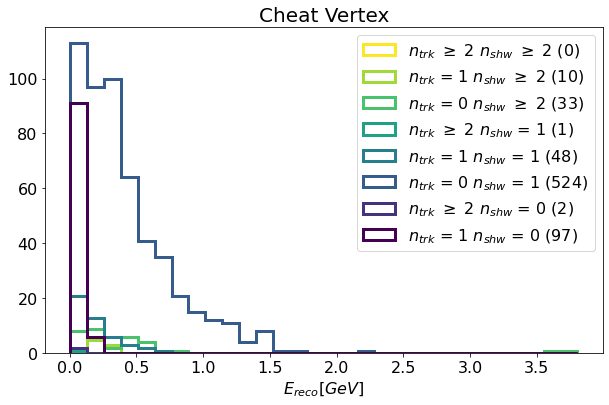

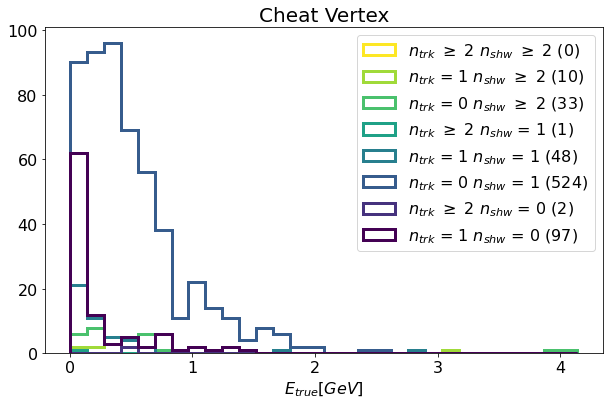

In [35]:
fig,ax = hist_nreco_vals(pfps,nreco_indeces[1:],nreco_labels[1:],
                'rec.slc.reco.pfp.shw.bestplane_energy',r'$E_{reco} [GeV]$',bins=30)
ax.set_title('Cheat Vertex')
plotters.set_style(ax)
plotters.save_plot('cheat_vtx_reco_eng')

fig,ax = hist_nreco_vals(electrons,nreco_indeces[1:],nreco_labels[1:],
                'rec.mc.nu.prim.genE',r'$E_{true} [GeV]$',bins=30)
ax.set_title('Cheat Vertex')
plotters.set_style(ax)
plotters.save_plot('cheat_vtx_true_eng')



In [102]:
pfps

rec.slc.reco.pfp.id  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           44             1                              0   
                           2                              0   
                           3                              0   
                           4                              0   
                           5                              0   
                           6                              0   
                           7                              0   
                           8                              0   
                           10                             0   

                                        rec.slc.reco.pfp.shw.bestplane  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                   
1           44             1                                         2   
                           2                                         0   
                           3                                         2   
                           4                                         2   
                           5                                         2   
                           6                                         2   
                           7                                         2   
                           8                                         2   
                           10                                        2   

                                        rec.slc.reco.pfp.shw.bestplane_dEdx  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             1                                       1.825588   
                           2                                       2.283176   
                           3                                       1.739795   
                           4                                       4.550286   
                           5                                       3.577097   
                           6                                       2.100808   
                           7                                       1.790617   
                           8                                       1.730602   
                           10                                      1.815367   

                                        rec.slc.reco.pfp.shw.bestplane_energy  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                          
1           44             1                                         0.487057   
                           2                                         0.067579   
                           3                                         0.162372   
                           4                                         0.527348   
                           5                                         0.013987   
                           6                                         0.461307   
                           7                                         1.361785   
                           8                                         0.051030   
                           10                                        0.258692   

                                        rec.slc.reco.pfp.shw.conversion_gap  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             1                                       0.109617   
                           2                                       0.269209   
                           3                                       0.125336   
                           4                                       0.165022   
                           5                                       3.703927   
                           6                                       4.027976   
                           7                                       4.676392   
                           8                              

In [13]:
#pfps.iloc[0].to_csv('test.csv')

In [15]:
pfps.loc[no_reco_indeces,'']

rec.slc.reco.pfp.id  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                        
1           44             1                              0   
                           2                              0   
                           3                              0   
                           4                              0   
                           5                              0   
                           6                              0   
                           7                              0   
                           8                              0   
                           10                             0   

                                        rec.slc.reco.pfp.shw.bestplane  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                   
1           44             1                                         2   
                           2                                         0   
                           3                                         2   
                           4                                         2   
                           5                                         2   
                           6                                         2   
                           7                                         2   
                           8                                         2   
                           10                                        2   

                                        rec.slc.reco.pfp.shw.bestplane_dEdx  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             1                                       1.825588   
                           2                                       2.283176   
                           3                                       1.739795   
                           4                                       4.550286   
                           5                                       3.577097   
                           6                                       2.100808   
                           7                                       1.790617   
                           8                                       1.730602   
                           10                                      1.815367   

                                        rec.slc.reco.pfp.shw.bestplane_energy  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                          
1           44             1                                         0.487057   
                           2                                         0.067579   
                           3                                         0.162372   
                           4                                         0.527348   
                           5                                         0.013987   
                           6                                         0.461307   
                           7                                         1.361785   
                           8                                         0.051030   
                           10                                        0.258692   

                                        rec.slc.reco.pfp.shw.conversion_gap  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                                        
1           44             1                                       0.109617   
                           2                                       0.269209   
                           3                                       0.125336   
                           4                                       0.165022   
                           5                                       3.703927   
                           6                                       4.027976   
                           7                                       4.676392   
                           8                              

In [97]:
mcprim.keys()
tree.keys()
pfps.loc[:,'rec.slc.reco.pfp.trackScore']

rec.hdr.run  rec.hdr.subrun  rec.hdr.evt
1            44              1             -5.000000
                             1              0.372414
                             2             -5.000000
                             2              0.433081
                             3             -5.000000
                             3              0.383097
                             4             -5.000000
                             4             -1.000000
                             4              0.318493
                             5             -5.000000
                             5              0.458729
                             6             -5.000000
                             6              0.382563
                             7             -5.000000
                             7              0.309075
                             8             -5.000000
                             8              0.581278
                             10            -5.000000
     

In [57]:
electrons = caf.get_electrons(mcprim)
electrons.loc[:,'rec.mc.nu.prim.pdg']

rec.hdr.run  rec.hdr.subrun  rec.hdr.evt
1            44              1              11
                             2              11
                             3              11
                             4              11
                             5              11
                             6              11
                             7              11
                             8              11
                             9              11
                             10             11
Name: rec.mc.nu.prim.pdg, dtype: int32

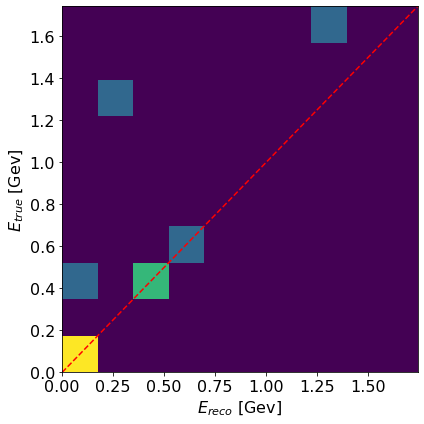

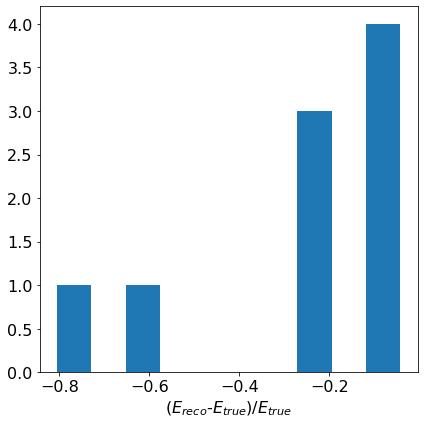

In [55]:
reco_eng = helpers.remove_dummy_values(pfps.loc[matched_indeces,'rec.slc.reco.pfp.shw.bestplane_energy'])
true_eng = mcprim.loc[matched_indeces,'rec.mc.nu.prim.genE'][mcprim.loc[matched_indeces,'rec.mc.nu.prim.pdg']==11]
fig,ax = hist2d_true_reco(reco_eng,true_eng,r'$E_{reco}$ [Gev]',r'$E_{true}$ [Gev]',plot_line=True)
fig,ax = plot_true_reco_err(reco_eng,true_eng,r'$E_{reco}$',r'$E_{true}$')

# OLD

In [99]:
#This is a problem, not an apples to apples comp.
reco_eng,true_eng

(rec.hdr.run  rec.hdr.subrun  rec.hdr.evt
 1            44              1              0.487057
                              2              0.067579
                              3              0.162372
                              4              0.005246
                              4              0.527348
                              5              0.013987
                              6              0.461307
                              7              1.361785
                              8              0.051030
                              10             0.258692
 Name: rec.slc.reco.pfp.shw.bestplane_energy, dtype: float32,
 rec.hdr.run  rec.hdr.subrun  rec.hdr.evt
 1            44              1              0.511966
                              2              0.070559
                              3              0.416918
                              4              0.590462
                              5              0.019100
                              6             

In [103]:
(pfps['rec.slc.reco.pfp.trackScore'] > 0.5).groupby(level=0).sum().values

array([1])

In [9]:
start = time.perf_counter()
# mcnu = ttree.get_mcnu(tree,bad_keys=mcnu_bad_keys,library='np')
# mcprim = ttree.get_mcprim(tree,bad_keys=mcprim_bad_keys,library='np')
# pfps_np = ttree.get_pfps(tree,pfp_keys=caf_constants.used_pfp_keys,bad_keys=pfp_bad_keys, library='np')
end = time.perf_counter()
print(f'Time = {end-start:.3f} (s)')

TypeError: 'numpy.uint32' object is not iterable

In [ ]:
(pfps_np - pfps).values

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,        nan,
               nan],
       [ 1.       , -7.       , -6.9538269, ...,  0.       ,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [10]:
ind = 0
f = f'{caf_constants.DATA_DIR}{caf_constants.FLAT_FILES[ind]}'
mcp_tree = uproot.open(f)
mcp_tree = mcp_tree[mcp_tree.keys()[0]]

In [14]:
mcnu = ttree.get_mcnu(mcp_tree,bad_keys=mcnu_bad_keys,library='pd')

In [ ]:
pfps.keys()

Index(['rec.slc.reco.pfp.id', 'rec.slc.reco.pfp.ndaughters',
       'rec.slc.reco.pfp.parent', 'rec.slc.reco.pfp.parent_is_primary',
       'rec.slc.reco.pfp.pfochar.chgendfrac',
       'rec.slc.reco.pfp.pfochar.chgfracspread',
       'rec.slc.reco.pfp.pfochar.linfitdiff',
       'rec.slc.reco.pfp.pfochar.linfitgaplen',
       'rec.slc.reco.pfp.pfochar.linfitlen',
       'rec.slc.reco.pfp.pfochar.linfitrms',
       ...
       'rec.slc.reco.pfp.trk.truth.p.startp.z',
       'rec.slc.reco.pfp.trk.truth.p.wallin',
       'rec.slc.reco.pfp.trk.truth.p.wallout',
       'rec.slc.reco.pfp.trk.truth.pur',
       'rec.slc.reco.pfp.trk.truth.visEintrk',
       'rec.slc.reco.stub.planes.hit_w', 'rec.slc.reco.stub.planes.p',
       'rec.slc.reco.stub.planes.pitch', 'rec.slc.reco.stub.planes.trkpitch',
       'rec.slc.reco.stub.planes.vtx_w'],
      dtype='object', length=282)

In [ ]:
a = list(pfps.keys())
a.extend(pfps.index.names)
new_row = np.full((3,len(pfps.keys())),-5)
for i,row in enumerate(new_row):
  new_row[i].extend()

array([[-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, 

In [ ]:
list(dfs[2].keys())

['rec.slc.reco.pfp.id',
 'rec.slc.reco.pfp.ndaughters',
 'rec.slc.reco.pfp.parent',
 'rec.slc.reco.pfp.parent_is_primary',
 'rec.slc.reco.pfp.pfochar.chgendfrac',
 'rec.slc.reco.pfp.pfochar.chgfracspread',
 'rec.slc.reco.pfp.pfochar.linfitdiff',
 'rec.slc.reco.pfp.pfochar.linfitgaplen',
 'rec.slc.reco.pfp.pfochar.linfitlen',
 'rec.slc.reco.pfp.pfochar.linfitrms',
 'rec.slc.reco.pfp.pfochar.openanglediff',
 'rec.slc.reco.pfp.pfochar.pca2ratio',
 'rec.slc.reco.pfp.pfochar.pca3ratio',
 'rec.slc.reco.pfp.pfochar.vtxdist',
 'rec.slc.reco.pfp.shw.bestplane',
 'rec.slc.reco.pfp.shw.bestplane_dEdx',
 'rec.slc.reco.pfp.shw.bestplane_energy',
 'rec.slc.reco.pfp.shw.conversion_gap',
 'rec.slc.reco.pfp.shw.cosmicDist',
 'rec.slc.reco.pfp.shw.density',
 'rec.slc.reco.pfp.shw.dir.x',
 'rec.slc.reco.pfp.shw.dir.y',
 'rec.slc.reco.pfp.shw.dir.z',
 'rec.slc.reco.pfp.shw.end.x',
 'rec.slc.reco.pfp.shw.end.y',
 'rec.slc.reco.pfp.shw.end.z',
 'rec.slc.reco.pfp.shw.len',
 'rec.slc.reco.pfp.shw.open_angle',

In [ ]:
pfps.loc[:,['rec.slc.reco.pfp.trackScore','rec.slc.reco.pfp.nshw','rec.slc.reco.pfp.ntrk']]

In [ ]:
list(dfs[2].keys())
dfs[2].loc[:,[ 
              'rec.slc.reco.pfp.shw.dir.x',
#  'rec.slc.reco.pfp.shw.dir.y',
#  'rec.slc.reco.pfp.shw.dir.z',
#  'rec.slc.reco.pfp.shw.end.x',
#  'rec.slc.reco.pfp.shw.end.y',
#  'rec.slc.reco.pfp.shw.end.z',
#  'rec.slc.reco.pfp.shw.len',
 'rec.slc.reco.pfp.trk.dir.x',
 'rec.slc.reco.pfp.trackScore',
#  'rec.slc.reco.pfp.trk.dir.y',
#  'rec.slc.reco.pfp.trk.dir.z',
#  'rec.slc.reco.pfp.trk.end.x',
#  'rec.slc.reco.pfp.trk.end.y',
#  'rec.slc.reco.pfp.trk.end.z',
#  'rec.slc.reco.pfp.trk.len',
 ]]

rec.slc.reco.pfp.shw.dir.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           0              1                                   NaN   
                           1                              0.051515   
                           2                                   NaN   
                           2                             -0.081089   

                                        rec.slc.reco.pfp.trk.dir.x  \
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           0              1                                   NaN   
                           1                             -0.955355   
                           2                                   NaN   
                           2                              0.040238   

                                        rec.slc.reco.pfp.trackScore  
rec.hdr.run rec.hdr.subrun rec.hdr.evt                               
1           0              1                                   -5.0  
                           1                                   -5.0  
                           2                                   -5.0  
                           2                                   -5.0

In [ ]:
tree.keys()

['rec.crt_hits..length',
 'rec.crt_hits.pe',
 'rec.crt_hits.plane',
 'rec.crt_hits.position.x',
 'rec.crt_hits.position.y',
 'rec.crt_hits.position.z',
 'rec.crt_hits.position_err.x',
 'rec.crt_hits.position_err.y',
 'rec.crt_hits.position_err.z',
 'rec.crt_hits.t0',
 'rec.crt_hits.t1',
 'rec.crt_hits.time',
 'rec.crt_tracks..length',
 'rec.crt_tracks.hita.pe',
 'rec.crt_tracks.hita.plane',
 'rec.crt_tracks.hita.position.x',
 'rec.crt_tracks.hita.position.y',
 'rec.crt_tracks.hita.position.z',
 'rec.crt_tracks.hita.position_err.x',
 'rec.crt_tracks.hita.position_err.y',
 'rec.crt_tracks.hita.position_err.z',
 'rec.crt_tracks.hita.t0',
 'rec.crt_tracks.hita.t1',
 'rec.crt_tracks.hita.time',
 'rec.crt_tracks.hitb.pe',
 'rec.crt_tracks.hitb.plane',
 'rec.crt_tracks.hitb.position.x',
 'rec.crt_tracks.hitb.position.y',
 'rec.crt_tracks.hitb.position.z',
 'rec.crt_tracks.hitb.position_err.x',
 'rec.crt_tracks.hitb.position_err.y',
 'rec.crt_tracks.hitb.position_err.z',
 'rec.crt_tracks.hitb.